# Предобработка данных

#### Подключение библиотек и скриптов

In [175]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 4. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [176]:
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [177]:
import datetime
now = datetime.datetime.now()

#### Пути к директориям и файлам

In [178]:
TRAIN_DATASET_PATH = 'C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\train.csv'
TEST_DATASET_PATH  = 'C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\test.csv'

# Шаг 1. Загрузка данных

In [179]:
# Оптимизация reduce_mem_usage

In [180]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Загрузка данных

**Data fields**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [194]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
# train_df = reduce_mem_usage(train_df)
train_df.head()

test_df = pd.read_csv(TEST_DATASET_PATH)

Оптимизация reduce_mem_usage 

In [195]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# Шаг 2. EDA и очистка данных

#### Оценка распредения целевой переменной в разрезе других признаков

Заполнение NaN

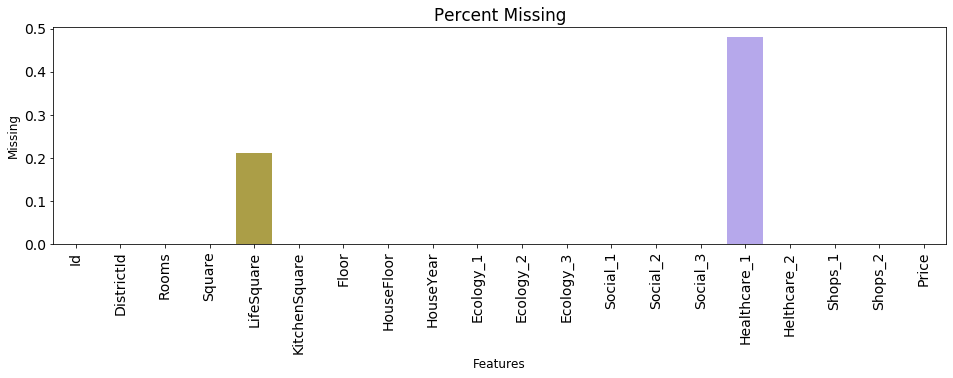

In [196]:
import seaborn as sns

nan_df = (train_df.isna().sum() / train_df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

*LifeSquare и Healthcare_1 имеют много пустых значений*

Комнаты

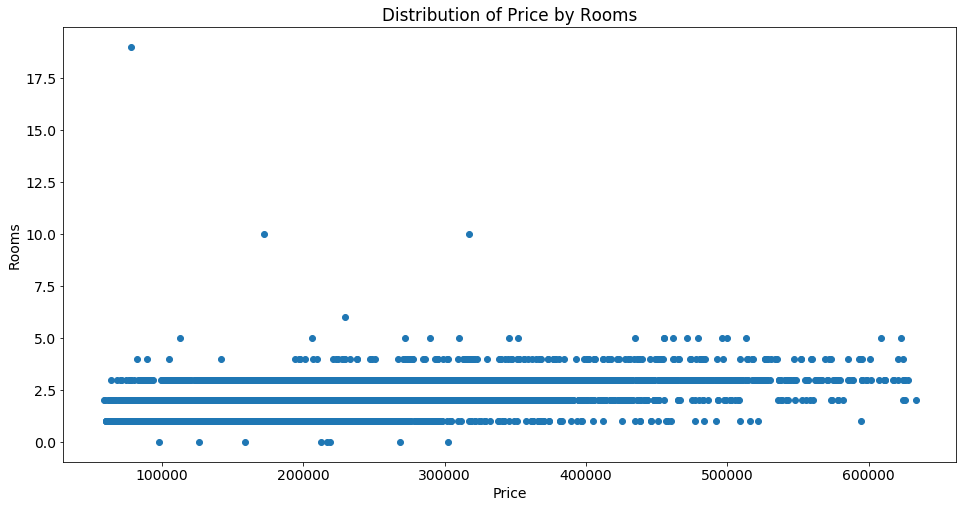

In [197]:
plt.figure(figsize=(16, 8))

plt.scatter(train_df['Price'], train_df['Rooms'])

plt.xlabel('Price')
plt.ylabel('Rooms')
plt.title('Distribution of Price by Rooms')
plt.show()

*В основном 1-3 комн, но есть пустые значения и выбросы*

In [191]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [192]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [193]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

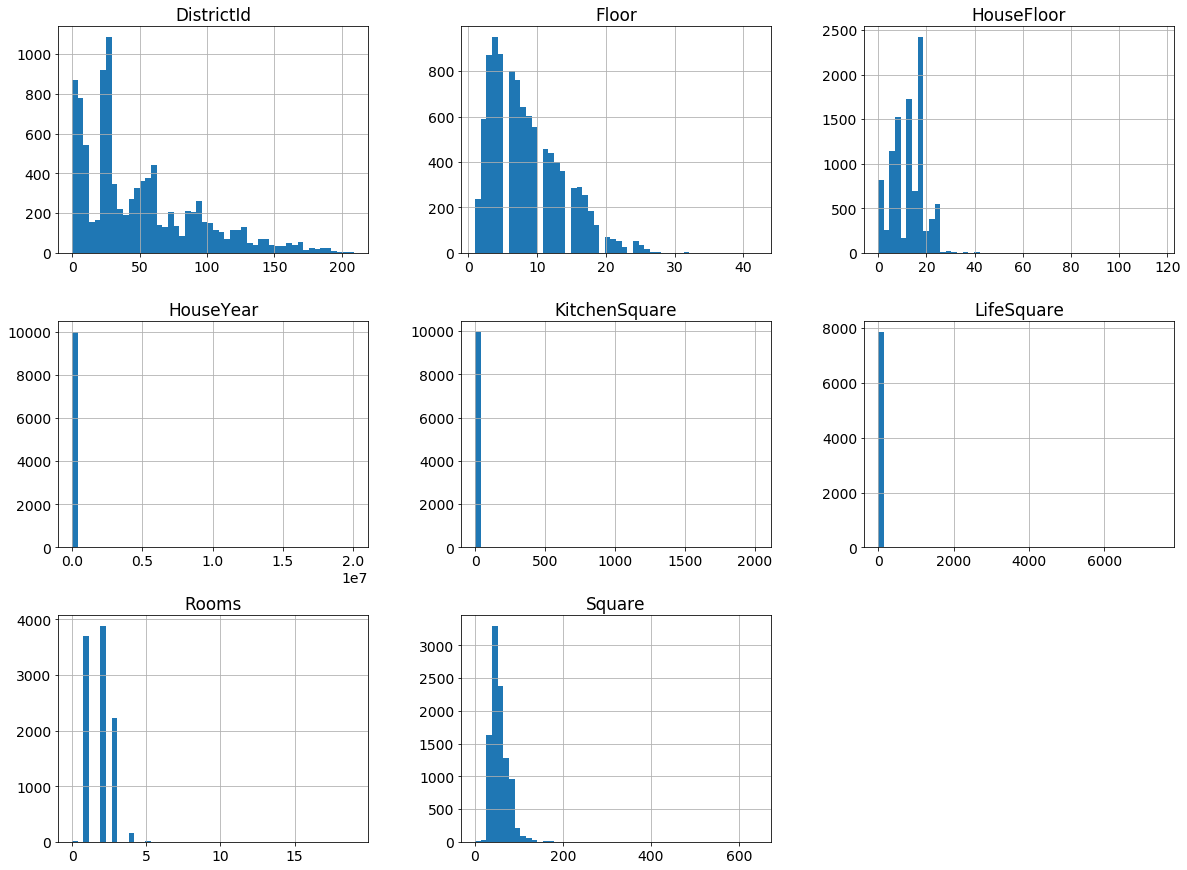

In [200]:
train_df[['DistrictId','Floor','HouseFloor','HouseYear','KitchenSquare','Rooms','Square','LifeSquare']].hist(bins=50, figsize=(20,15))
plt.show()

#### Анализ целевой переменной

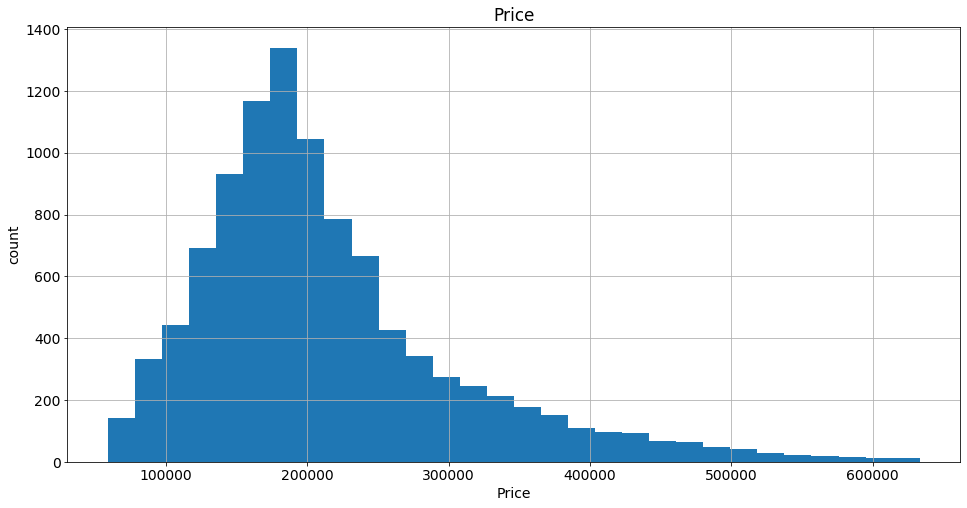

In [153]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Price')
plt.show()

# Шаг 3: Очистка данных и Feature engineering

### Приведение типов данных

In [154]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [155]:
train_df['Id'] = train_df['Id'].astype(str)


### Обработка данных

In [156]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.DistrictId_counts = None
        self.med_price_by_district = None

    def fit(self, df):
        """Сохранение статистик"""
        # Расчетет медиан
        self.LifeSquare_median = df['LifeSquare'].median()
        self.Square_median = df['Square'].median()
        self.Rooms_median  = df['Rooms'].median()
        self.HouseYear     = df['HouseYear'].median()
        self.HouseFloor    = df['HouseFloor'].median()
        self.Floor    = df['Floor'].median()
        self.KitchenSquare    = df['KitchenSquare'].median()
        # DistrictID
        district = df['DistrictId'].value_counts()
        district = district[district > 50]
        self.DistrictId_counts = dict(district)
        
        X = df.copy()
        X['DistrictId_popular'] = X['DistrictId'].copy()
        X.loc[~X['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
        
        # добавление признака средней стоимости м2 по району
        self.med_price_by_district = X.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
                
        
    def transform(self, df):
        # * Square - площадь
        # Оставляем записи где площадь больше 15
        # df = df[df.Square > 15] удалять записи нельзя
        df.loc[(df['Square'] > 280), 'Square'] = ((df.loc[(df['Square'] > 280), 'Square']) / 10)
        df.loc[(df['Square'] < 16), 'Square'] = ((df.loc[(df['Square'] < 16), 'Square']) * 10)

        
        # * LifeSquare - жилая площадь
        # Ищем процентное соотношение площади и жилой площади
        lsq_r =  self.LifeSquare_median / self.Square_median
        # Заполняем жилую площадь
        df.loc[(df['LifeSquare']== 0) | (df['LifeSquare'].isna()),'LifeSquare'] = df['Square'] - df['KitchenSquare']
        df.loc[(df['LifeSquare'] < 6 ) | (df['LifeSquare'] > df['Square']),'LifeSquare'] = df['Square']*lsq_r
        
        # * Rooms - количество комнат
        # Средняя площать комнаты
        sq_r = self.Square_median / self.Rooms_median
        # Заполняем комнаты как общая плщадь на среднюю площадь комнаты
        df.loc[(df['Rooms']==0) | (df['Rooms'] > 6), 'Rooms'] = df['Square']/sq_r
        df['Rooms'] = df['Rooms'].astype(int)
        
        # * Rooms - количество комнат
        # Оставляем записи где год актуальный
        df.loc[df['HouseYear'] > now.year,'HouseYear'] = now.year
        
        # KitchenSquare
        sqr_k = self.KitchenSquare / self.Square_median
        df.loc[(df['KitchenSquare'] < 5) | (df['LifeSquare'] < df['KitchenSquare']), 'KitchenSquare'] = df['Square']*sqr_k
        # df.loc[(df['KitchenSquare'] > df['Square']*0.9), 'KitchenSquare'] = df['Square']*sqr_k
              
         # HouseFloor, Floor
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.HouseFloor
        df.loc[df['Floor'] == 0, 'Floor'] = self.Floor
        
        #df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] > 48), 'HouseFloor'] = self.HouseFloor
        #f.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']
        #Первый и последний этажи многоэтажки
        # df.loc[(df['Floor'] == 1) & ( df['HouseFloor'] > 4 ) , 'Floor_first'] = 1       
        # df.loc[df['Floor_first'].isna(),'Floor_first'] = 0
        # df.loc[(df['Floor'] == df['HouseFloor']) & ( df['HouseFloor'] > 4 ) , 'Floor_last'] = 1
        # df.loc[df['Floor_last'].isna(),'Floor_last'] = 0
        
        # District
        df['DistrictId_count'] = df['DistrictId'].map(self.DistrictId_counts)
        df['DistrictId_count'].fillna(df['DistrictId_count'].median(), inplace=True)
        
         # добавление признака средней стоимости м2 по району
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
                       
        # * Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
        #median = df['Healthcare_1'].median()
        #df.loc[(df['Healthcare_1']== 0) | (df['Healthcare_1'].isna()),'Healthcare_1'] = df['Healthcare_1'].fillna(median)
        
        # Отбор и построение новых признаков (фичей) 'Ecology_2', 'Ecology_3','Shops_2
        df = pd.get_dummies(df, columns=['Ecology_2', 'Ecology_3','Shops_2'])
        
        return df

In [157]:
pipe = DataPipeline()
pipe.fit(train_df) # расчет статисстик
train_df = pipe.transform(train_df)

In [159]:
train_df.sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Price,DistrictId_count,MedPriceByDistrict,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
6392,14786,1,1,11.368588,7.096803,1.298938,3.0,1.0,1977,0.007122,...,1,181434.825589,652.0,146735.671740,0,1,0,1,0,1
7767,6927,21,1,16.117154,8.822988,1.841494,2.0,5.0,1965,0.194489,...,5,79913.267856,165.0,153921.400690,0,1,0,1,0,1
5617,15877,57,3,16.547242,10.329561,8.000000,5.0,5.0,1962,0.133215,...,4,77835.185808,107.0,305780.187311,0,1,0,1,1,0
3166,15127,150,1,17.046188,10.641026,8.000000,7.0,12.0,1982,0.300323,...,9,74222.110465,165.0,NaN,0,1,0,1,0,1
6945,12927,62,2,17.414181,16.414181,1.989688,4.0,20.0,1977,0.072158,...,0,180750.471749,247.0,178912.369081,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,3718,56,3,190.857689,107.376164,19.000000,7.0,3.0,2007,0.000000,...,6,338644.075979,165.0,NaN,0,1,0,1,0,1
8511,4249,23,5,198.930182,123.139863,10.000000,1.0,2.0,2011,0.014073,...,0,345665.209100,565.0,345665.209100,0,1,0,1,0,1
9910,16568,27,4,200.334539,125.058174,25.000000,1.0,2.0,2013,0.041116,...,4,528560.506016,851.0,309311.697054,0,1,0,1,0,1
1981,7917,27,8,212.932361,211.231125,24.328959,2.0,3.0,2008,0.211401,...,1,302211.260887,851.0,NaN,0,1,0,1,0,1


In [160]:
# test_df.sort_values(by='HouseFloor')
# test_df.loc[test_df['Floor'] > test_df['HouseFloor']].sort_values(by='Floor')

### Отбор и построение новых признаков (фичей)

#### Оставим признаки, которые необходимы для модели

In [161]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'DistrictId_count',
 'MedPriceByDistrict',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [162]:
feature_names = [
 'DistrictId',
 'MedPriceByDistrict',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Shops_1',
 'Helthcare_2']

target_name = 'Price'

In [163]:
train_df = train_df[feature_names + [target_name]]
train_df.head(4)

,DistrictId,MedPriceByDistrict,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Shops_1,Helthcare_2,Price
0,35,NaN,2,47.981561,29.442751,6.000000,7.0,9.0,1969,0.089040,33,11,0,184966.930730
1,41,300009.450063,3,65.683640,40.049543,8.000000,7.0,9.0,1978,0.000070,46,16,1,300009.450063
2,53,263206.223152,2,44.947953,29.197612,5.135607,8.0,12.0,1968,0.049637,34,3,1,220925.908524
3,58,166809.665642,2,53.352981,52.731512,9.000000,8.0,17.0,1977,0.437885,23,5,0,175616.227217


### Сохранение  датасета

In [164]:
# DATASET_PATH = 'C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\train.csv'
# df.to_csv(DATASET_PATH, index=False, encoding='utf-8')

# Шаг 4. Разбиение на train / test

In [165]:
X = train_df[feature_names]
y = train_df[target_name]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

# Шаг 5. Построение моделей

Бизнес метрика - R^2, Root Mean Squared Error (RMSE)

In [166]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.3  LGBMRegressor

In [167]:
model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.749 +- 0.016


In [168]:
model.fit(X, y)

### Расчет цены для тестовых данных

In [169]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [170]:
# pipe = DataPipeline()
test_df = pipe.transform(test_df)

In [171]:
test_df.sort_values(by='LifeSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,DistrictId_count,MedPriceByDistrict,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
66,9011,53,1,13.785426,8.605507,1.575078,1.0,1.0,1977,0.049637,...,1,3,174.0,195474.299127,0,1,0,1,0,1
3697,15435,21,1,133.055315,9.495367,15.202468,6.0,5.0,1965,0.194489,...,3,5,165.0,153921.400690,0,1,0,1,0,1
1195,3969,101,1,18.149267,9.698766,2.073676,4.0,5.0,1967,0.225825,...,3,2,97.0,151926.384470,1,0,0,1,0,1
926,13828,34,3,89.482970,10.692499,10.000000,11.0,17.0,1998,0.069753,...,1,11,111.0,332572.312994,0,1,0,1,0,1
4430,5038,58,2,53.190041,10.816033,9.000000,15.0,14.0,2005,0.050756,...,0,1,179.0,166809.665642,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,1686,62,3,137.653211,136.921090,15.727808,4.0,3.0,1977,0.072158,...,0,0,247.0,213915.960440,0,1,0,1,1,0
4865,5424,93,3,137.987412,136.987412,15.765993,2.0,3.0,1977,0.004949,...,0,0,73.0,198524.447471,0,1,0,1,0,1
4567,14196,113,3,138.409213,137.409213,15.814187,19.0,18.0,2016,0.050756,...,0,1,143.0,NaN,0,1,0,1,0,1
2371,1929,62,3,148.783492,148.783492,16.999518,5.0,5.0,1977,0.072158,...,0,0,247.0,213915.960440,0,1,0,1,1,0


### Создаем датафрейм с предсказаниями модели

In [172]:
X_final = test_df

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)
X_final = X_final[feature_names]

#### Выгружаем предсказания в файл

In [173]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head(20)

,Id,Price
0,725,144840.726062
1,15856,226419.057316
2,5480,343048.472834
3,15664,327731.463030
4,14275,153716.738146
5,7633,225604.347765
6,13329,175960.044040
7,5502,227652.917280
8,4220,271171.872830
9,11538,197621.125411
